# Dimensionality Reduction with PCA on MNIST images

# Load dependencies and data

In [1]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm


In [2]:
# Load only training samples form mnist
mnist = tfds.load('mnist', split='train', shuffle_files=True, as_supervised=True)
# Leave only samples with labels 4, 7, or 8
mnist = mnist.filter(lambda x, y: tf.reduce_all(tf.not_equal(y, [0,1,2,3,5,6,9])))

In [3]:
mnist_numpy = []
labels = []
for X, y in tfds.as_numpy(mnist):
    mnist_numpy.append(X)
    labels.append(y)
mnist_numpy = np.array(mnist_numpy).squeeze()
shape = mnist_numpy.shape
mnist_numpy_reshape = np.reshape(mnist_numpy, (shape[0], shape[1] * shape[2]))
mnist_numpy_reshape.shape

(17958, 784)

# PCA Camperock

On this section, the class PCACamperock is presented. This class contains a custom implementation of the PCA algorithm.

Note to future self: The variances of the principal componenets are the eigenvalues, while the components are the eigenvectors. If we sum the eigenvalues, from the n_components and divide that by the sum of ALL the eigenvalues, we get the percentage of the variance that we have left after the dimensionality reduction (self.preserved_variance_ratio in the code).

In [4]:
class PCACamperock:
    def __init__(self, n_components, random_state=42):
        self.n_components = n_components
        self.random_state = 42
    
    def fit_transform(self, X_train):
        self.X_train_mean = np.mean(X_train, axis=0)
        # Substract the mean from the data
        self.X_meaned = X_train - self.X_train_mean
        
        # Calculate covariance matrix
        cov_mat = np.cov(self.X_meaned, rowvar=False)
        
        # Eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov_mat)
        
        # Sort eigenvalues and eigenvectors
        indices = np.argsort(eigenvalues)[::-1]
        self.eigenvalues = eigenvalues[indices]
        eigenvectors = eigenvectors[:, indices]
        
        # Get n_components
        self.components = eigenvectors[:, :self.n_components]  # (784, n_components)
        
        # Transform original data
        self.X_transformed = self.X_meaned @ self.components  # (n, n_components)
        
        # Get preserved variance ratio
        total_variance = np.sum(self.eigenvalues)
        self.preserved_variance_ratio = np.array(
            [value / total_variance for value in self.eigenvalues[:self.n_components]]
        )
        
        return self
    
    def reverse_transform(self):
        '''
        Returns the reverse transform of the original data used for training
        '''
        X_reverse = (self.X_transformed @ self.components.T) + self.X_train_mean
        return X_reverse
    
pca_camperock = PCACamperock(n_components=100).fit_transform(mnist_numpy_reshape)

# Plot eigenvalues

Preserved variance with 100 Principal components: 91.64%


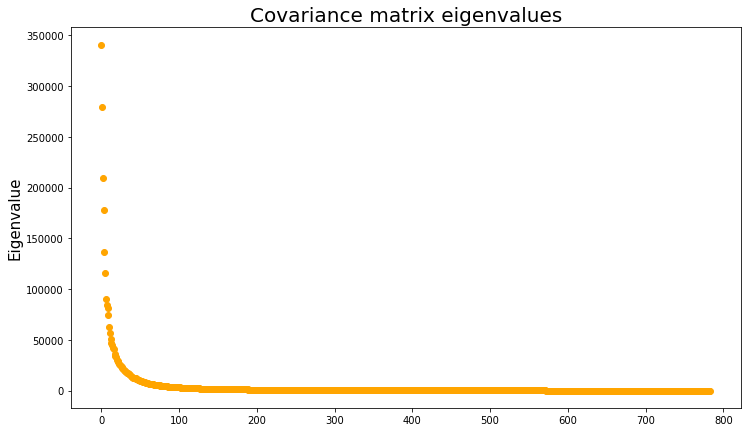

In [5]:
x_axis = np.arange(0, pca_camperock.eigenvalues.shape[0])

preserved_variance = round(pca_camperock.preserved_variance_ratio.sum() * 100, 2)
print(f'Preserved variance with 100 Principal components: {preserved_variance}%')
plt.figure(figsize=(12, 7))
plt.title('Covariance matrix eigenvalues', size = 20)
plt.ylabel('Eigenvalue', size=15)
plt.scatter(x_axis, pca_camperock.eigenvalues, color='orange')
plt.show()

## How many components should we use to keep 98% of the variability

I will proceed to look for the answer to this question by iteration.

By doing this we can determine that we would need to use 247 Principal Components to preserve 98% of the original variability.

In [6]:
# Get preserved variance ratio
total_variance = np.sum(pca_camperock.eigenvalues)

for i in range(0, 784):
    preserved_variance_ratio = np.array(
        [value / total_variance for value in pca_camperock.eigenvalues[:i]]
    )
    if preserved_variance_ratio.sum() >= 0.98:
        print(f'Needed Principal Components: {i}')
        break

Needed Principal Components: 247


## Principal components visualization for fun

We can visualize some of the principal components given by the eigenvectors.

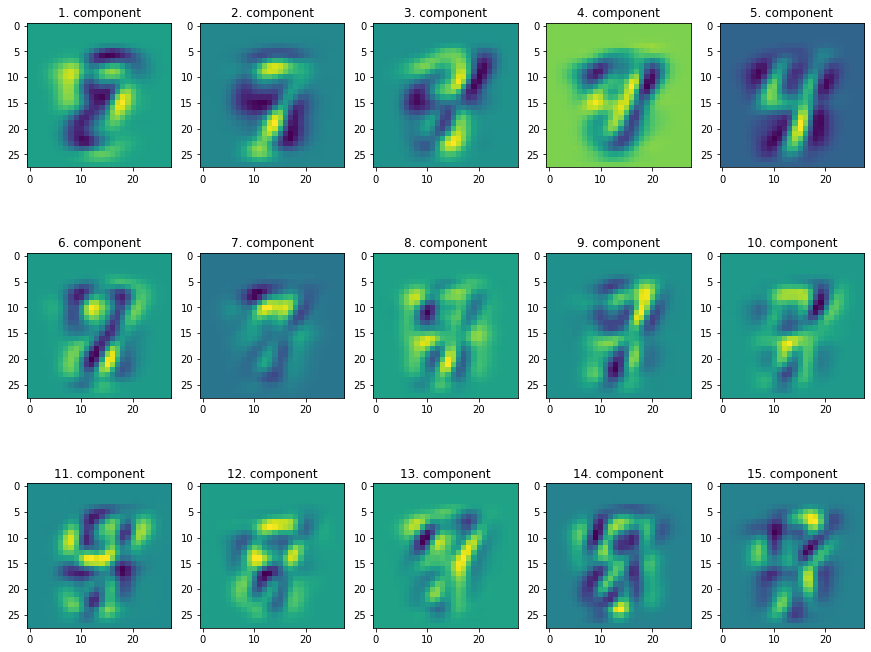

In [7]:
fig, axes = plt.subplots(3, 5, figsize=(15,12))

for i, (component, ax) in enumerate(zip(pca_camperock.components.T, axes.ravel())):
    ax.imshow(component.reshape(shape[1:]))
    ax.set_title(f'{i + 1}. component')

# Recover images from the PCA features

Originally, only 100 components are used, from the original 784 features. The images can be reconstructed and the numbers are recognizable, but some distortion is present in the images.

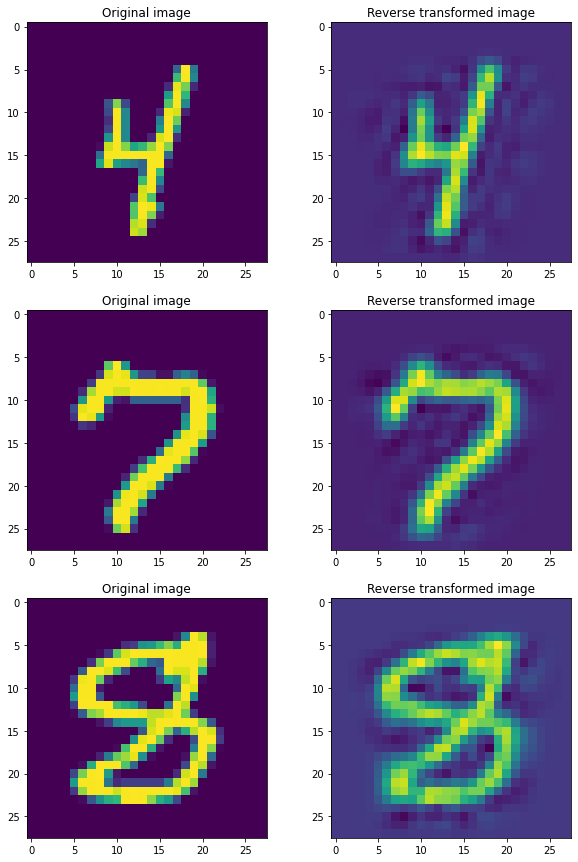

In [8]:
X_reverse_transformed = pca_camperock.reverse_transform()
X_reverse_transformed = np.reshape(X_reverse_transformed, (shape[0], shape[1], shape[2]))

fig, axes = plt.subplots(3, 2, figsize=(10,15))
for i in range(3):
    axes[i, 0].imshow(mnist_numpy[i])
    axes[i, 0].set_title(f'Original image')
    
    axes[i, 1].imshow(X_reverse_transformed[i])
    axes[i, 1].set_title(f'Reverse transformed image')

## Try with different number of dimensions

In this section, we will plot a random image of the dataset, and its reconstruction after the PCA analysis. The less dimensions that are used for the reduction, the more blury the reconstruction becomes. Additionally, when using only 2 dimensions the reconstruction looks generic, it doesn't contain distinct features of the original image, like the tilt in the number. After using 500 dimensions, the reconstruction is almost perfect.

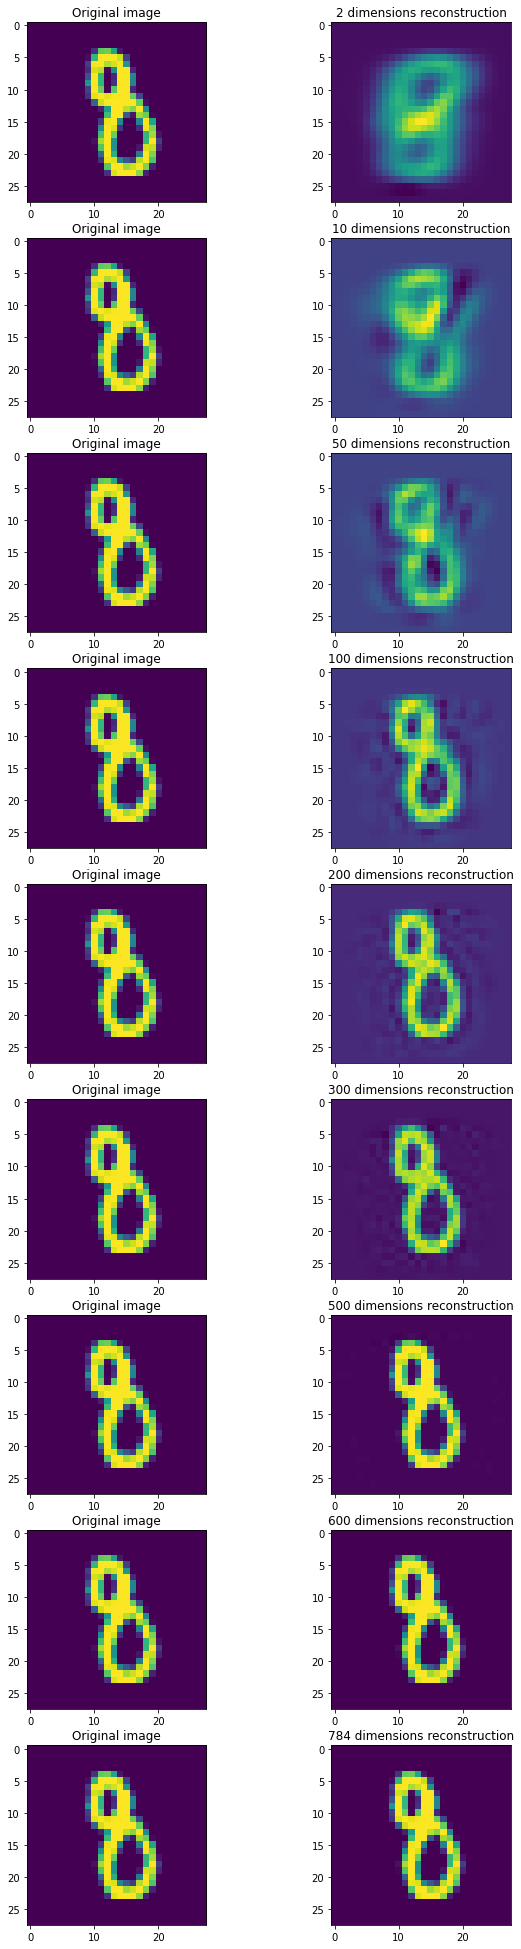

In [9]:
np.random.seed(69)
image_index = np.random.randint(0, shape[0])

fig, axes = plt.subplots(9, 2, figsize=(10,35))

errors = []
dims = [2, 10, 50, 100, 200, 300, 500, 600, 784]

for i, n_dims in enumerate(dims):
    pca_dims = PCACamperock(n_components=n_dims).fit_transform(mnist_numpy_reshape)
    dims_reversed = pca_dims.reverse_transform()
    dims_reversed = np.reshape(dims_reversed, (shape[0], shape[1], shape[2]))
    errors.append( np.mean( (dims_reversed - mnist_numpy) ** 2 ) )
    
    axes[i, 0].imshow(mnist_numpy[image_index])
    axes[i, 0].set_title(f'Original image')
    
    axes[i, 1].imshow(dims_reversed[image_index])
    axes[i, 1].set_title(f'{n_dims} dimensions reconstruction')
plt.show()

From the following scatter plot we can conclude that the more dimensions we use, the less error while reconstructing the original data and, therefore, the better the quality in the reconstructed images.

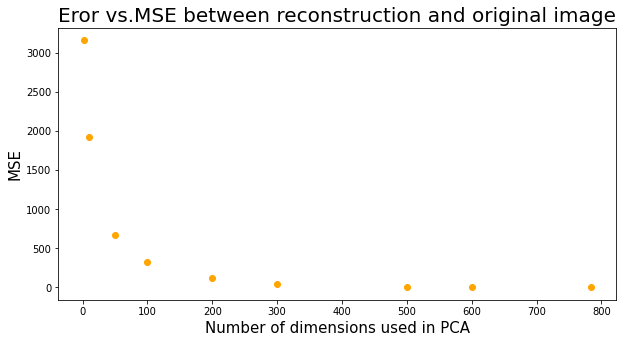

In [10]:
plt.figure(figsize=(10, 5))

plt.title('Eror vs.MSE between reconstruction and original image', size=20)

plt.ylabel('MSE', size=15)
plt.xlabel('Number of dimensions used in PCA', size=15)
plt.scatter(dims, errors, color='orange')
plt.show()